In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

/Users/louis/mambaforge/envs/morph/lib/python3.8/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [2]:
import jax.numpy as np
from jax import jit, value_and_grad, vmap
from jax.tree_util import tree_structure
import optax
import numpy as onp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle as p
import time as t

In [3]:
import poppy
import astropy.units as u

In [4]:
import equinox as eqx
import equinox

---
# Base Classes

In [5]:
# Base Classes
class Layer(eqx.Module):
    """
    Base Layer class
    Can optionally pass in 'function' in order to facilitate parameterised planes
    Can optionally pass in 'static' to automatically freeze in the parameters
    """
    size_in: int = equinox.static_field()
    size_out: int = equinox.static_field()
    
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out

class OpticalSystem(eqx.Module):
    """
    Base class defining some optical system
    layers must be a list of Layer objects
    Each layer object can either be some optical operation, 
    transform, or NN type layer
    """
    layers: list 
    
    def __init__(self, layers):
        self.layers = layers
        
    def __call__(self, wavel):
        wavefront = self.layers[0](wavel) # Always assumed to be CreateWavefront layer
        for i in range(1, len(self.layers)):
            wavefront = self.layers[i](wavefront, wavel)
        return np.abs(wavefront)**2

---

## Layer Sub-Classes

In [6]:
class CreateWavefront(Layer):
    """
    Initialises an input wavefront
    x and y should be in radians (measured from the optical axis)
        How to pass in aperture to this robustly? As a property of the osys?
        What if we want to optimise the aperture size? 
        Shuould this exist outside of the system?
        Always propagate on axis and and shift with the offset term in MFT?
    To Do: Test this properly
    """
    x: float
    y: float
    aperture: float
    
    # def __init__(self, size, optic_size):
    def __init__(self, size):
        """
        size: Size of the array
        
        array_size: This physical size of the input wavefront (m)
            This value is used to determine the pixelscale and coordinate
            arrays that are tracked throughout propagation for fresnel
        """
        self.size_in = size
        self.size_out = size
        self.x = 0.
        self.y = 0.
        self.aperture = aperture
    
    def __call__(self, wavel):
    # def __call__(self, x, y, wavel):
        """
        x and y are assumed to be in radians (are they lol),  deivation from the optical
        axis
        optic_size is assumed to be in meters
        """

        npix = self.size_in
        x, y = self.x, self.y
        aperture = self.aperture

        rmax = np.hypot(x, y)
        phi_rot = np.arctan2(y, x)
        opd_max = aperture * np.sin(rmax)
        phase_max = opd_to_phase(opd_max, wavel)

        # Figure out which one of these is right
        phase_slope = np.linspace(0, phase_max, npix, endpoint=False)
        phase_array = np.tile(phase_slope, [npix, 1])

        xs = np.linspace(0, np.pi/4, npix, endpoint=False)
        XX, YY = np.meshgrid(xs, xs)
        RR = np.hypot(XX, YY)
        PHI = np.arctan2(YY, XX) - phi_rot
        phase_out = rmax * RR * np.sin(PHI)
        wavefront_out = np.ones([npix, npix]) * np.exp(1j * phase_out)

        return wavefront_out
    
class NormaliseWavefront(Layer):
    """
    Normalises the input wavefront
    """
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
    
    def __call__(self, wavefront, dummy_wavel):
        norm_factor = np.sqrt(np.sum(np.abs(wavefront)**2))
        norm_wavefront = wavefront/norm_factor
        return norm_wavefront
    
class MFT(Layer):
    """
    Matches poppy but assumes square
    """
    wavel_scale: float = equinox.static_field()    
    
    def __init__(self, size_in, size_out, wavel_scale):
        self.size_in = size_in
        self.size_out = size_out
        self.wavel_scale = wavel_scale
        
    def __call__(self, wavefront, wavel):
        """
        Should we add offset here too?
        I have removed it but we have the code needed in the old notebooks
        
        Add shift parameter?
        """
        npup, npix = self.size_in, self.size_out
        nlamD = self.wavel_scale / wavel
        
        dX = 1.0 / float(npup)
        dU = nlamD / float(npix)
        # Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0 + 0.5) * dX
        # Us = (np.arange(npix, dtype=float) - float(npix) / 2.0 + 0.5) * dU
        Xs = (np.arange(npup, dtype=float) - float(npup) / 2.0) * dX
        Us = (np.arange(npix, dtype=float) - float(npix) / 2.0) * dU
        XU = np.outer(Xs, Us)
        expXU = np.exp(-2.0 * np.pi * 1j * XU)

        # Note: Can casue overflow issues on 32-bit
        norm_coeff = np.sqrt((nlamD**2) / (npup**2 * npix**2)) 

        # Perform MFT
        t1 = np.dot(expXU.T, wavefront)
        t2 = np.dot(t1, expXU)
        return norm_coeff * t2
    
class AddPhase(Layer):
    """
    Adds an array of values to the input wavefront
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, complex_array, dummy_wavel):
        
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array) + self.array
        return amplitude * np.exp(1j*phase)
    
class ApplyOPD(Layer):
    """
    Adds an array of phase values to the input wavefront calculated from the OPD
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, complex_array, wavel):
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array)
        phase_in = self._opd_to_phase(self.array, wavel)
        phase_out = phase + phase_in
        return amplitude * np.exp(1j*phase_out)
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
class ApplyZernike(Layer):
    """
    Adds an array of phase values to the input wavefront calculated from the OPD
    """
    nterms: int = equinox.static_field()
    basis: jax.numpy.ndarray = equinox.static_field()
    coefficients: jax.numpy.ndarray
    
    def __init__(self, size, nterms, coefficients):
        self.size_in = size
        self.size_out = size
        self.nterms = nterms
        self.coefficients = coefficients
        # Load basis
        self.basis = np.array(np.nan_to_num(
            poppy.zernike.zernike_basis(nterms=nterms+3, npix=size)[3:])).T
        print("Note Zernike Ignores Piston Tip Tilt")
        
    def __call__(self, complex_array, wavel):
        amplitude = np.abs(complex_array)
        phase = np.angle(complex_array)
        zernike_opd = np.dot(self.basis, self.coefficients)
        zernike_phase = self._opd_to_phase(zernike_opd, wavel)
        phase_out = phase + zernike_phase
        return amplitude * np.exp(1j*phase_out)
    
    def _opd_to_phase(self, opd, wavel):
        return 2*np.pi*opd/wavel
    
    def get_total_opd(self):
        return np.dot(self.basis, self.coefficients)

In [7]:
class MultiplyArray(Layer):
    """
    Multiplies the input wavefront by an array
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, array, dummy_wavel):
        return np.multiply(array, self.array)

class AddScalar(Layer):
    """
    Add a scalar to the input wavefront
    """
    value: float
    def __init__(self, size, value):
        self.size_in = size
        self.size_out = size
        self.value = value
        
    def __call__(self, array, dummy_wavel):
        return np.add(array, self.value) 

class AddArray(Layer):
    """
    Adds an array of values to the input wavefront
    """
    array: jax.numpy.ndarray
    def __init__(self, size, array):
        self.size_in = size
        self.size_out = size
        self.array = array
    
    def __call__(self, array, dummy_wavel):
        return np.add(array, self.array)
    
class MultiplyScalar(Layer):
    """
    Multiplies the input wavefront by a scalar
    """
    value: float
    def __init__(self, size, value):
        self.size_in = size
        self.size_out = size
        self.value = value
        
    def __call__(self, array, dummy_wavel):
        return np.multiply(array, self.value) 

class Pad(Layer):
    
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out
    
    def __call__(self, array, dummy_wavel):
        """
        Pads the input to the given size
        Places the array in the center
        """
        c, s = self.size_out//2, self.size_in//2
        padded = np.zeros([self.size_out, self.size_out], dtype=array.dtype)
        return padded.at[c-s:c+s, c-s:c+s].set(array)
    
class Crop(Layer):
    
    def __init__(self, size_in, size_out):
        self.size_in = size_in
        self.size_out = size_out
    
    def __call__(self, array, dummy_wavel):
        """
        Crops the input to the given size
        Crops from the center
        """
        c, s = self.size_in//2, self.size_out//2
        return array[c-s:c+s, c-s:c+s]

In [8]:
class FresnelProp(Layer):
    """
    Layer for Fresnel propagation
    
    Note this algorithm is completely not intensity conservative and will
    give different answers for each wavelength too
    
    Note this probably gives wrong answers for tilted input wavefronts becuase
    I believe its based on the paraxial wave equation and tilted wavefronts
    are not paraxial
    
    -> Do something clever with MFTs in the final TF with the offset term to 
    get propper off axis behaviour?
    """
    pixelscale: float = equinox.static_field()
    x_coords: jax.numpy.ndarray
    y_coords: jax.numpy.ndarray
    z: float
    
    # def __init__(self, size, z, pixelscale):
    def __init__(self, size, z, aperture):
        """
        Initialisation
        pixelscale must be in m/pixel, ie aperture/npix
        """
        self.size_in = size
        self.size_out = size
        self.z = z
        self.pixelscale = aperture/size # m/pix ie pixel size (OF THE APERTURE)

        # Check if this matches PSF centering
        xs = np.arange(0, size) - size//2 
        XX, YY = np.meshgrid(xs, xs)
        self.x_coords = XX * self.pixelscale
        self.y_coords = YY * self.pixelscale
        
        
    def __call__(self, wavefront, wavel):
        """
        Propagates Fresnel
        """
        
        # Wave number
        k = 2*np.pi / wavel
        
        # Units: pixels * m / pixel = m 'simulation size'
        s = self.size_in * self.pixelscale 
            
        # First Phase Operation
        rho1 = np.exp(1.0j * k * (self.x_coords ** 2 + self.y_coords ** 2) / (2 * self.z))
        wavefront *= rho1
        
        # Assume z > 0 for now
        wavefront = np.fft.ifftshift(wavefront)
        wavefront = np.fft.fft2(wavefront)
        wavefront = np.fft.fftshift(wavefront)
        wavefront *= self.pixelscale ** 2
        
        # Second Phase Operation
        rho2 = np.exp(1.0j * k * self.z) / (1.0j * wavel * self.z) * np.exp(1.0j * k * 
                                (self.x_coords ** 2 + self.y_coords ** 2) / (2 * self.z))
        wavefront *= rho2
        return wavefront
        
class ThinLens(Layer):
    pixelscale: float = equinox.static_field()
    r_coords: jax.numpy.ndarray = equinox.static_field()
    f: float
    
    def __init__(self, size, f, aperture):
        self.size_in = size
        self.size_out = size
        self.f = f
        self.pixelscale = aperture/size # m/pix ie pixel size (OF THE APERTURE)

        # Check if this matches PSF centering
        xs = np.arange(0, size) - size//2 
        XX, YY = np.meshgrid(xs, xs)
        x_coords = XX * self.pixelscale
        y_coords = YY * self.pixelscale
        self.r_coords = np.hypot(x_coords, y_coords)
        
    
    def __call__(self, wavefront, wavel):
        """
        k: Wavenumber
        f: Focal length (m)
        x/y_coords: spatial coordinate system (m)
        """
        k = 2*np.pi / wavel
        return wavefront * np.exp(-0.5j * k * self.r_coords**2 * 1/self.f)
    
class FFT(Layer):
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
        
    def __call__(self, wavefront, dummy_wavel):
        """
        Performs normalisation matching poppy
        """
        norm = wavefront.shape[0]
        array_out = norm * np.fft.fftshift( np.fft.ifft2(wavefront) )
        return array_out 
    
class IFFT(Layer):
    def __init__(self, size):
        self.size_in = size
        self.size_out = size
        
    def __call__(self, wavefront, dummy_wavel):
        """
        Performs normalisation matching poppy
        """
        norm = 1./array.shape[0]
        array_out = norm * np.fft.fft2( np.fft.ifftshift(array) )
        return array_out

In [9]:
# def InvertXY(array, dummy_wavel):
#     """
#     Layer for axis invertions
#     """
#     return array[::-1, ::-1]
    
# def InvertX(array, dummy_wavel):
#     """
#     Layer for axis invertions
#     """
#     return array[:, ::-1]
    
# def InvertY(array, dummy_wavel):
#     """
#     Layer for axis invertions
#     """
#     return array[::-1]

--- 

## Functions

In [10]:
# Helper functions
def opd_to_phase(opd, wavel):
    return 2*np.pi*opd/wavel

def phase_to_opd(phase, wavel):
    return (phase * wavel)/(2*np.pi)

def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = np.linspace(-c, c, size, endpoint=False)
    Xs, Ys = np.meshgrid(xs, xs)
    Rs = np.hypot(Xs, Ys)
    
    if radius is None:
        aperture = np.where(Rs > c, 0, np.ones([size, size]))
    else:
        aperture = np.where(Rs > radius, 0, np.ones([size, size]))
    return aperture

def get_toliman_pupil(size, path=None, asymmetric=False):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    from scipy.ndimage import zoom
    if path is None:
        if asymmetric is False:
            toliman_pupil = np.load("Toliman_pupil.npy")
    else:
        if asymmetric is False:
            toliman_pupil = np.load("{}/Toliman_pupil.npy".format(path))
        
    phase = np.angle(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * np.exp(1j * phase_scaled)
    return toliman_pupil_out

def create_aperture(npix):
    # Create aperture
    xs = np.arange(-npix//2, npix//2)
    XX, YY = np.meshgrid(xs, xs)
    RR = np.hypot(XX, YY)
    aperture = RR < npix//2
    return aperture

---

### Osys creation

Define some osys by a list of layers

In [25]:
"""
Determining Coordinate Grids
Assume Each layer has some input 'optic/aperture dimension', 'oversampling/pad factor' and 'npix'
"""

# Define Parameters (Optical)
wavel = 600e-9         # Arbitray at this point (m)
optic_size = 1.        # Physical size of input optic array, ie aperture size for simple system (m)
focal_length = 5.      # (m)

# Define Parameters (Arrays/sizes)
optic_npix = 256       # Number of pixels in the wf/optic before oversampling (pix)
oversample = 16        # Oversapling/padding factor
det_npix = 128         # Number of pixels in the focal plane

################################################################################

# Calculate Relevant Array Sizes 
wf_size = optic_size * oversample                         # Physical size of wavefront array (m)
wf_npix = optic_npix * oversample                         # Dimension of TF'd Wavefront (pix)
crop_factor = wf_npix/det_npix                            # Crop factor for FFT calc

# Pupil Plane Pixel Scale
pupil_pixelscale = optic_size/optic_npix                  # (m/pix), same as below
wf_pixelscale = wf_size/wf_npix                           # (m/pix), same as above

# Focal Plane Pixel Scale (ie pixel size)
wf_pixelscale_focal = 2 * wavel * focal_length / wf_size  # Pixel scale in the focal plane (m/pix)
wf_size_focal = wf_pixelscale_focal * wf_npix             # Physical size of output wavefront in the focal plane (m)
det_size = wf_pixelscale_focal * det_npix                 # Physical size of detector in the focal plane (m)

# Re-name for use with MFT 
pixel_size = wf_pixelscale_focal                           # (m/pix)
det_size = det_npix * pixel_size                           # (m)

# Calculate parameters
FoV_angular = 2 * np.arctan(0.5 * det_size / focal_length) # (rads)
wavel_scale = FoV_angular * optic_size                     # (rad m)
nlamD = wavel_scale/wavel                                  # (radians) -> Units seem wrong here

################################################################################

# Airy disk analytic Parameters
airy_fringe_size_angular = 1.22 * wavel / optic_size                # (rads)
airy_fringe_size = focal_length * np.sin(airy_fringe_size_angular)  # (m)
airy_fringe_per_pix = pixel_size/airy_fringe_size                   # (pix^-1)
airy_pix_per_fringe = airy_fringe_size/pixel_size                   # (pix)
airy_NlamD = airy_fringe_per_pix * det_npix                         # ()

################################################################################

print("Input Params:")
print("    Wavelength in: {} nm".format(wavel*1e9))
print("    Focal Length: {} m".format(focal_length))
print("    Aperture: {} m".format(optic_size))
print("    Optic npix: {} pix".format(optic_npix))
print("    Oversample Factor: {}".format(oversample))
print()

print("Pupil Plane Params")
print("    Wavefront Size: {} m".format(wf_size))
print("    Wavefront npix: {} pix".format(wf_npix))
print("    Wavefront pscale: {} mm/pix".format(wf_pixelscale*1e3))
print()

print("Focal Plane Params:")
print("    Wavefornt pscale (Focal): {:.3f} um/pix".format(wf_pixelscale_focal*1e6))
print("    Wavefront size (Focal): {:.3f} mm".format(wf_size_focal*1e3))
print("    Detector npix: {} pix".format(det_npix))
print("    Detector size: {:.3f} mm".format(det_size*1e3))
print()

print("MFT Params")
print("    Num Fringes MFT: {:.2f}".format(nlamD))
print()

print("Airy Parameters:")
print("    Airy Fringe Size: {:.3f} u radians".format(airy_fringe_size_angular*1e6))
print("    Airy Fringe Size: {:.3f} um".format(airy_fringe_size*1e6))
print("    Airy Fringe per Pixel: {:.3f} (pix^-1)".format(airy_fringe_per_pix))
print("    Airy Pixel per Fringe: {:.3f} (pix)".format(airy_pix_per_fringe))
print("    Airy Num Fringes: {:.2f}".format(airy_NlamD))

Input Params:
    Wavelength in: 600.0 nm
    Focal Length: 5.0 m
    Aperture: 1.0 m
    Optic npix: 256 pix
    Oversample Factor: 16

Pupil Plane Params
    Wavefront Size: 16.0 m
    Wavefront npix: 4096 pix
    Wavefront pscale: 3.90625 mm/pix

Focal Plane Params:
    Wavefornt pscale (Focal): 0.375 um/pix
    Wavefront size (Focal): 1.536 mm
    Detector npix: 128 pix
    Detector size: 0.048 mm

MFT Params
    Num Fringes MFT: 16.00

Airy Parameters:
    Airy Fringe Size: 0.732 u radians
    Airy Fringe Size: 3.660 um
    Airy Fringe per Pixel: 0.102 (pix^-1)
    Airy Pixel per Fringe: 9.760 (pix)
    Airy Num Fringes: 13.11


In [26]:
# # Pupil plane coordinates
# xs = (np.arange(0, npix) - npix//2) * pupil_pixelscale # From (-optic_size/2, optic_size/2]
# XX_coords, YY_coords = np.meshgrid(xs, xs)

In [13]:
# min_wavel = 550e-9
# max_wavel = 600e-9
min_wavel = wavel
max_wavel = wavel
mean_wavel = (max_wavel + min_wavel)/2
nwavels = 1
wavels = np.linspace(min_wavel, max_wavel, nwavels)

npix = optic_npix

In [14]:
aperture = create_aperture(optic_npix)
# aperture = np.ones([optic_npix, optic_npix])

In [15]:
FFT_layers = [CreateWavefront(optic_npix),                  # Wavefront creation
              MultiplyArray(optic_npix, aperture),          # Apply aperture
              NormaliseWavefront(optic_npix),               # Normalise input power
              Pad(optic_npix, wf_npix),                     # Pad
              FFT(wf_npix),                                 # FFT
              Crop(wf_npix, det_npix)]                      # Crop # SHOULD REALLY BE CROP THEN INTERPOLATE (or intepolate crop?)

fl = focal_length
FNL_layers = [CreateWavefront(optic_npix),                  # Wavefront creation
              MultiplyArray(optic_npix, aperture),          # Apply aperture
              NormaliseWavefront(optic_npix),               # Normalise input power
              ThinLens(optic_npix, fl, optic_size),         # Thin lens
              Pad(optic_npix, wf_npix),                     # Pad
              FresnelProp(wf_npix, fl, wf_size),            # Fresnel
              Crop(wf_npix, det_npix)]                      # Crop # SHOULD REALLY BE CROP THEN INTERPOLATE (or intepolate crop?)

MFT_layers = [CreateWavefront(optic_npix),                  # Wavefront creation
              MultiplyArray(optic_npix, aperture),          # Apply aperture
              NormaliseWavefront(optic_npix),               # Normalise input power
              MFT(optic_npix, det_npix, 0.5*wavel_scale)] # So theres a factor of two miss match somewhere :'( or i understand nyquist wrong

In [16]:
FFT_model = OpticalSystem(FFT_layers)
FNL_model = OpticalSystem(FNL_layers)
MFT_model = OpticalSystem(MFT_layers)

FFT_data = vmap(FFT_model)(wavels).sum(0)
FNL_data = vmap(FNL_model)(wavels).sum(0)
MFT_data = vmap(MFT_model)(wavels).sum(0)

FNL_norm = np.sum(FFT_data) * FNL_data/FNL_data.sum() # Because Fresnel is un-normalised

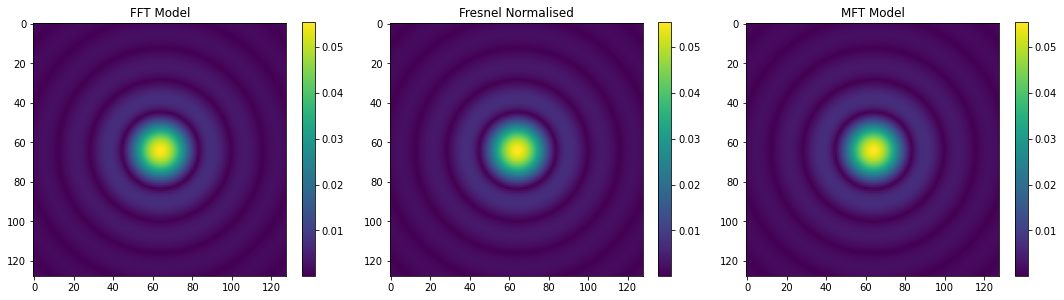

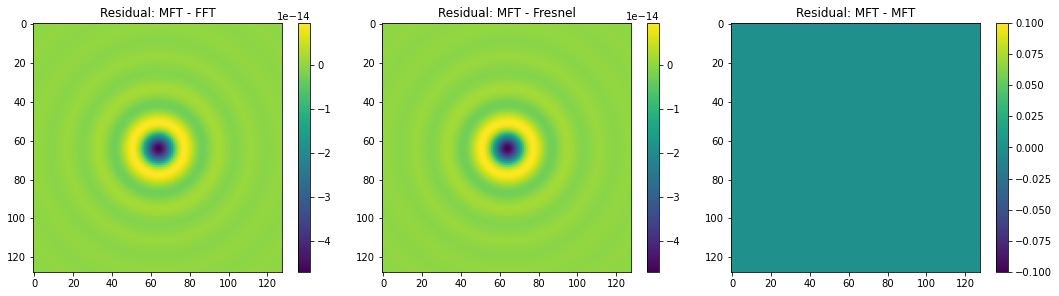

In [17]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("FFT Model")
plt.imshow(FFT_data**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Fresnel Normalised")
plt.imshow(FNL_norm**0.5)
# plt.imshow(FNL_norm**0.5)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("MFT Model")
plt.imshow(MFT_data**0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Residual: MFT - FFT")
plt.imshow(MFT_data - FFT_data)
# plt.imshow(np.abs(MFT_data - FFT_data)**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Residual: MFT - Fresnel")
plt.imshow(MFT_data - FNL_norm)
# plt.imshow(np.abs(MFT_data - FNL_norm)**0.5)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual: MFT - MFT")
plt.imshow(MFT_data - MFT_data)
# plt.imshow(np.abs(MFT_data - MFT_data)**0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

In [24]:
print(np.allclose(MFT_data, FFT_data))
print(np.allclose(MFT_data, FNL_norm))

True
True


### Zernike Phase Ret

In [19]:

# # Zernikes
# nterms = 7 #12
# onp.random.seed(0)
# coeffs_true = 0.4*mean_wavel*np.array(onp.random.rand(nterms)-0.5)

### Toliman Phase Ret

In [20]:
# For Toliman Phase-Ret
# aperture = create_aperture(npix)
# pupil_phase = np.angle(get_toliman_pupil(npix, path='..'))
# opd_true = phase_to_opd(pupil_phase, mean_wavel)
# onp.random.seed(0)
# opd_start = phase_to_opd(np.array(2*np.pi*onp.random.rand(npix**2)).reshape([npix, npix]), mean_wavel)

In [21]:
# z = 1e-10
# z = 0
# pixelscale = 1e-6

fl = 1. # 1m
shift = 5e-2
zs = fl + np.linspace(-shift, shift, 5)

z = 1. - 1e-2
s = 0.1 # Aperture size

# pixelscale = s/npix

In [23]:


# layers2 = [CreateWavefront(npix),                  # Wavefront creation
#           MultiplyArray(npix, aperture),          # Apply aperture
#           NormaliseWavefront(npix),               # Normalise input power
#           ThinLens(npix, fl, s),
#           Pad(npix, pad_factor*npix),
#           FresnelProp(pad_factor*npix, z/2, s*pad_factor),
#           FresnelProp(pad_factor*npix, z/2, s*pad_factor),
#           Crop(pad_factor*npix, npix)]
          # MFT(npix, npix, wavel_scale)]           # Tranform to focal plane

# # Optimisation Model
# layers_init = [CreateWavefront(npix),             # Wavefront creation
#                MultiplyArray(npix, aperture),     # Apply aperture
#                NormaliseWavefront(npix),          # Normalise input power
#                ApplyOPD(npix, opd_start),         # Apply Phase Screen
#                MFT(npix, npix, wavel_scale)]      # Tranform to focal plane

---

## From Poppy propagate_direct():

self.pixelscale = self.wavelength * abs(z) / s / u.pix

 - Maybe this 'z' is the equivilent to non-thinlens (free space) propagation z so find relationship with lens power?
 
### Physical size of the output wavefront
 - after an FFT will depend on wavelength and padding factor
 - wavefront size s will scale linearly with padding factor
 - Derive NlamD from the physical size the detector and the size of the fringes (calc using final wf physical size after FFT?)
 - So Frenel WF size a fraction of this final result with prop distance?
 
 2x padding = Nyquist sampled pixels so derive pixel size/scale directly from the padding factor
 1x padding = half Nyqiust sampled
 Nyquist sampling == a single fringe


 -> determine final wf size as based on nfringes (from padding and npix) and size of those fringes (1.22lam/D)?
 -> Calculate angular coords of wavefront in intermedary plane as fraction of fl travelled from the initial pixelscale and the pixel scale in focal plane

In [ ]:
pixelscale = wavel * np.abs(z) / s # POST PROPAGATION

In [879]:
model = OpticalSystem(layers)
model2 = OpticalSystem(layers2)

data = vmap(model)(wavels).sum(0)
data2 = vmap(model2)(wavels).sum(0)

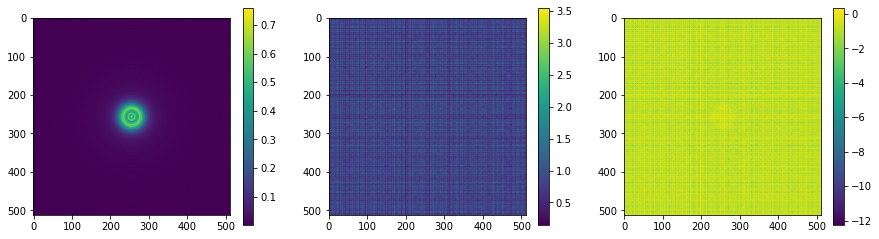

In [880]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
# plt.title("Sqrt Initial PSF")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(1, 3, 2)
# plt.title("Sqrt Target PSF")
plt.imshow(data2**0.5)
plt.colorbar()

plt.subplot(1, 3, 3)
# plt.title("Initial Residual PSF")
plt.imshow(data-data2)
plt.colorbar()
plt.show()

In [838]:
data_all = []

for i in range(len(zs)):
    
    z = zs[i]
    layers = [CreateWavefront(npix),                  # Wavefront creation
              MultiplyArray(npix, aperture),          # Apply aperture
              NormaliseWavefront(npix),               # Normalise input power
              ThinLens(npix, fl, s),
              Pad(npix, pad_factor*npix),
              FresnelProp(pad_factor*npix, z, s*pad_factor),
              Crop(pad_factor*npix, npix)]

    ideal_model = OpticalSystem(layers)
    data_raw = vmap(ideal_model)(wavels)
    data_norm = np.dot(data_raw.T, 1/data_raw.sum([1, 2]))
    data_all.append(data_norm)
    # data = data_norm.sum(0)
    # initial_psf = vmap(model)(wavels).sum(0)

## Do we need to add thinlens?

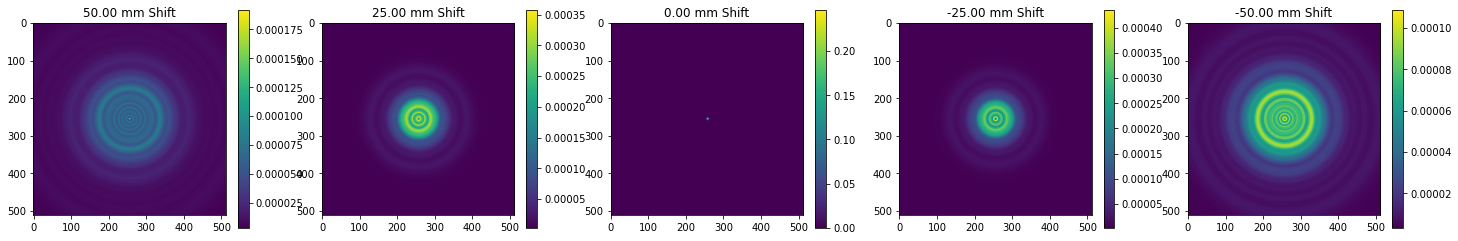

In [839]:


plt.figure(figsize=(25, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title("{:.2f} mm Shift".format((1-zs[i])*1e3))
    plt.imshow(data_all[i])
    plt.colorbar()
plt.show()

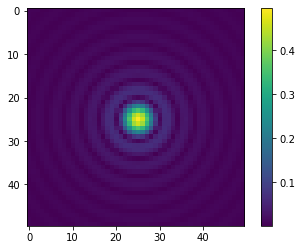

In [840]:
im = data_all[2]
c = im.shape[0]//2
s = 25

plt.imshow(im[c-s:c+s, c-s:c+s]**0.5)
plt.colorbar()
plt.show()

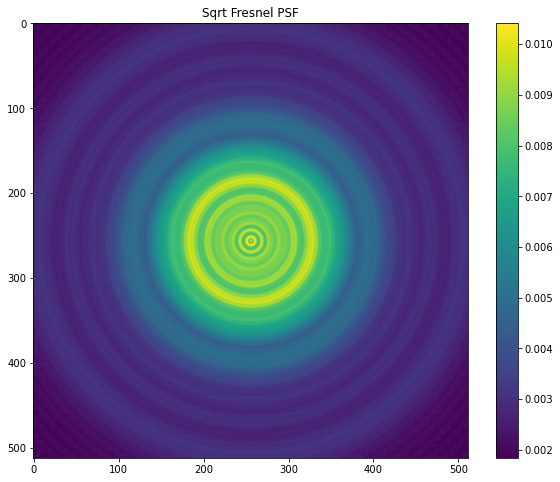

In [841]:
plt.figure(figsize=(10, 8))
plt.title("Sqrt Fresnel PSF")
plt.imshow(data_norm**0.5)
plt.colorbar()

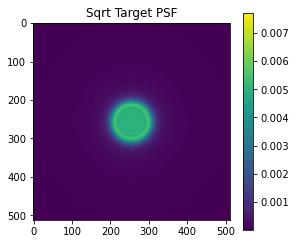

In [553]:
plt.figure(figsize=(15, 4))
# plt.subplot(1, 3, 1)
# plt.title("Sqrt Initial PSF")
# plt.imshow(initial_psf**0.5)
# plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Sqrt Target PSF")
plt.imshow(data**0.5)
plt.colorbar()

# plt.subplot(1, 3, 3)
# plt.title("Initial Residual PSF")
# plt.imshow(data-initial_psf)
# plt.colorbar()
# plt.show()

In [426]:
# self.size_in = size
# self.size_out = size
# self.z = z
# self.pixelscale = pixelscale # m/pix ie pixel size

# Check if this matches PSF centering


In [431]:
z = 1e4
wavel = 5.45e-3
N = 512
s = 1. # 1m aperture

pixelscale = s/N
k = 2*np.pi / wavel


xs = np.arange(0, N) - N//2 
XX, YY = np.meshgrid(xs, xs)
x_coords = XX * pixelscale
y_coords = YY * pixelscale

print(k)


rho1 = np.exp(1.0j * k * (x_coords ** 2 + y_coords ** 2) / (2 * z))

1152.878038014603


In [589]:
xs

DeviceArray([-256, -255, -254, -253, -252, -251, -250, -249, -248, -247,
             -246, -245, -244, -243, -242, -241, -240, -239, -238, -237,
             -236, -235, -234, -233, -232, -231, -230, -229, -228, -227,
             -226, -225, -224, -223, -222, -221, -220, -219, -218, -217,
             -216, -215, -214, -213, -212, -211, -210, -209, -208, -207,
             -206, -205, -204, -203, -202, -201, -200, -199, -198, -197,
             -196, -195, -194, -193, -192, -191, -190, -189, -188, -187,
             -186, -185, -184, -183, -182, -181, -180, -179, -178, -177,
             -176, -175, -174, -173, -172, -171, -170, -169, -168, -167,
             -166, -165, -164, -163, -162, -161, -160, -159, -158, -157,
             -156, -155, -154, -153, -152, -151, -150, -149, -148, -147,
             -146, -145, -144, -143, -142, -141, -140, -139, -138, -137,
             -136, -135, -134, -133, -132, -131, -130, -129, -128, -127,
             -126, -125, -124, -123, -122, -121, -1

In [430]:
x_coords

DeviceArray([[-0.5]], dtype=float64, weak_type=True)

In [ ]:
# Wave number

# print(wavel)

# Units: pixels * m / pixel = m 'simulation size'
# s = self.size_in * self.pixelscale 

# First Phase Operation
rho1 = np.exp(1.0j * k * (self.x_coords ** 2 + self.y_coords ** 2) / (2 * self.z))
wavefront *= rho1
print(np.max(rho1), np.min(rho1))

# Assume z > 0 for now
wavefront = np.fft.ifftshift(wavefront)
# wavefront = np.fft.fft_2d(wavefront, forward=True, fftshift=False) # Figure out which is which
# wavefront = np.fft.fft2(wavefront)
# wavefront = FFT(wavefront, None)
wavefront = np.fft.fft2(wavefront)
wavefront = np.fft.fftshift(wavefront)
wavefront *= self.pixelscale ** 2

# Second Phase Operation
rho2 = np.exp(1.0j * k * self.z) / (1.0j * wavel * self.z) * np.exp(1.0j * k * 
                        (self.x_coords ** 2 + self.y_coords ** 2) / (2 * self.z))
wavefront *= rho2
print(np.max(rho2), np.min(rho2))

return wavefront

## Optimisaion

In [95]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_func(model, wavels, data):
    psf = vmap(model)(wavels).sum(0)
    return np.sum((psf - data)**2)

In [96]:
model = OpticalSystem(layers_init)
optim = optax.adam(1e-7)
opt_state = optim.init(model)

errors, grads_out = [], []
for i in tqdm(range(1000)):

    loss, grads = loss_func(model, wavels, data)    
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    errors.append(loss)
    grads_out.append(grads)

  0%|          | 0/1000 [00:00<?, ?it/s]

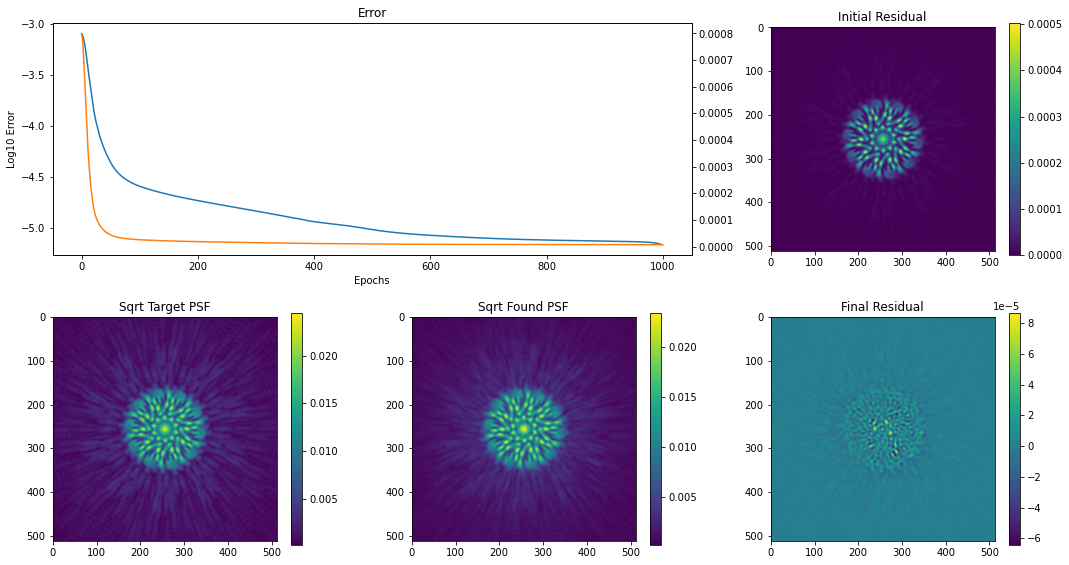

In [97]:
final_psf = vmap(model)(wavels).sum(0)
residual = data - final_psf
initial_residual = data - initial_psf

vmin = np.min(initial_residual)
vmax = np.max(initial_residual)

plt.figure(figsize=(15, 8))
ax = plt.subplot(2, 3, (1,2))
plt.title("Error")
plt.plot(np.arange(len(errors)), np.log10(np.array(errors)))
plt.xlabel("Epochs")
plt.ylabel("Log10 Error")
# plt.ylabel("Error")
ax2 = ax.twinx()
ax2.plot(np.arange(len(errors)), np.array(errors), c='tab:orange')

plt.subplot(2, 3, 3)
plt.title("Initial Residual")
# plt.imshow(data**0.5)
plt.imshow(initial_residual)
plt.colorbar()

plt.subplot(2, 3, 4)
plt.title("Sqrt Target PSF")
plt.imshow(data**0.5)
plt.colorbar()

plt.subplot(2, 3, 5)
plt.title("Sqrt Found PSF")
im = plt.imshow(final_psf**0.5)
cbar = plt.colorbar(im)
plt.subplot(2, 3, 6)

plt.title("Final Residual")
plt.imshow(residual)#, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.tight_layout()
plt.show()

In [100]:
opd_in = ideal_model.layers[3].array
opd_out = model.layers[3].array
opd_out -= np.min(opd_out) # Normalise 
residual = opd_in - opd_out

RMSE_inital = opd_to_phase(np.sqrt(np.mean(opd_in**2)), mean_wavel)
RMSE_final  = opd_to_phase(np.sqrt(np.mean(residual**2)), mean_wavel)
print("Initial RMS Phase Error: {}".format(RMSE_inital))
print("Final RMS Phase Error:   {}".format(RMSE_final))

vmin = np.min(np.array([opd_in, opd_out]))
vmax = np.max(np.array([opd_in, opd_out]))

Initial RMS Phase Error: 2.0170021665960665
Final RMS Phase Error:   12.199641346047626


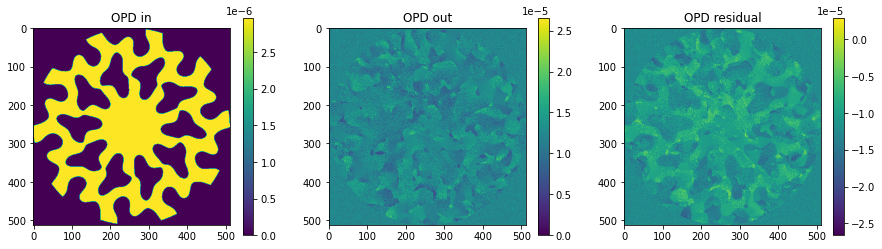

In [101]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("OPD in")
plt.imshow(opd_in)#, vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(opd_out)#, vmin=vmin, vmax=vmax)
plt.title("OPD out")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(residual)#, vmin=vmin, vmax=vmax)
plt.title("OPD residual")
plt.colorbar()
plt.show()

In [73]:
# coeffs_out = model.layers[3].coefficients[1:]
# coeffs_in = ideal_model.layers[3].coefficients[1:]
# vmin = np.min(np.array([coeffs_out, coeffs_in]))
# vmax = np.max(np.array([coeffs_out, coeffs_in]))
# residual = coeffs_in - coeffs_out

# plt.figure(figsize=(8, 5))
# plt.title("Coeffients")
# plt.xlabel("Coefficient index")
# plt.ylabel("Coefficient Amplitude")

# ax = plt.subplot(111)
# ax.scatter(np.arange(nterms-1)+3-0.2, coeffs_in, s=100, label='Coefficient in')
# ax.scatter(np.arange(nterms-1)+3   , coeffs_out, s=100, label='Coefficient out', alpha=0.9)
# ax.bar([], [], alpha=0.8, width=0.2, label="Resdiuals")
# ax.legend()

# ax2 = ax.twinx()
# ax2.set_ylabel("Resdiaul")
# ax2.bar(np.arange(len(residual))+3+0.2, residual, width=0.2, alpha=0.8)#, c='tab:green')
# ax2.set_ylim(vmin, vmax)
# ax2.axhline(0, c='k')
# plt.show()

In [151]:
model_partition = eqx.partition(model, eqx.is_array)
Mosys_partition = eqx.partition(Mosys, eqx.is_array)

# print(model_partition)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


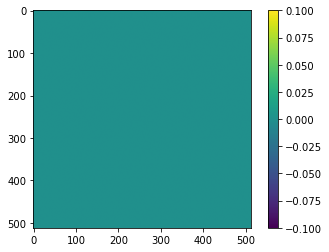

In [152]:
# aperture = model_partition[0].layers[1].array
# phases = model_partition[0].layers[3].array

aperture = Mosys_partition[0].layers[1].array


phases = Mosys_partition[0].layers[3].array

print(phases)

out = aperture*phases

c = out.shape[0]//2
s = 256
plt.imshow(out[c-s:c+s, c-s:c+s])
plt.colorbar()

In [102]:
psf_out = model(1e-5)

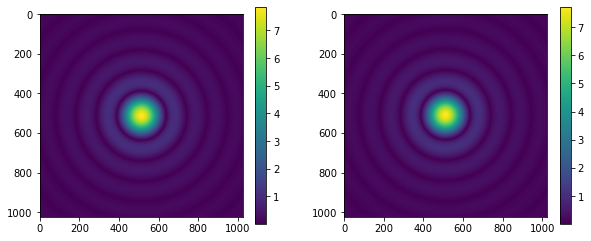

In [154]:
npix = 1024

# Create aperture
xs = np.arange(-npix//2, npix//2)
XX, YY = np.meshgrid(xs, xs)
RR = np.hypot(XX, YY)
aperture = RR < npix//2

wavel_scale = 1e-4
random_phases = 0.95 * np.array(onp.random.rand(npix**2).reshape([npix, npix])*2*np.pi)

In [155]:
layers = [
    CreateWavefront(npix),         # Wavefront creation
    MultiplyArray(npix, aperture), # Apply aperture
    NormaliseWavefront(npix),            # Normalise input power
    AddPhase(npix, np.zeros([npix, npix])),  # Apply Phase Screen
    MFT(npix, npix, wavel_scale)   # Tranform to focal plane
]

layers_noise = [
    CreateWavefront(npix),               # Wavefront creation
    MultiplyArray(npix, aperture),       # Apply aperture
    NormaliseWavefront(npix),                  # Normalise input power
    AddPhase(npix, random_phases),  # Apply Phase Screen
    MFT(npix, npix, wavel_scale)         # Tranform to focal plane
]

In [177]:
# Mosys =       vmap(OpticalSystem(layers))
# Mosys_noise = vmap(OpticalSystem(layers_noise))
Mosys =       OpticalSystem(layers)
Mosys_noise = OpticalSystem(layers_noise)

In [178]:
wavels = np.linspace(1e-5, 2e-5, 11)

model = Mosys_noise
psf_null  = np.sum(vmap(Mosys)(wavels), axis=0)
psf_noise = np.sum(vmap(Mosys_noise)(wavels), axis=0)

In [179]:
@eqx.filter_jit
@eqx.filter_value_and_grad
def loss_func(model, wavel, data):
    psf = np.sum(vmap(model)(wavels), axis=0)
    return np.sum((psf - data)**2)

In [180]:
errors = []
for i in tqdm(range(25)):
    optim = optax.adam(1e-4)
    opt_state = optim.init(model)
    loss, grads = loss_func(model, 1e-5, psf_null)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    
    # print(loss)
    errors.append(loss)

    # print(f"step={step}, loss={loss}")


  0%|          | 0/25 [00:00<?, ?it/s]

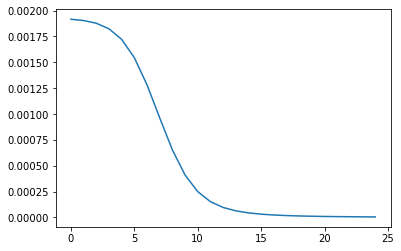

In [181]:
plt.plot(np.arange(len(errors)), errors)

1


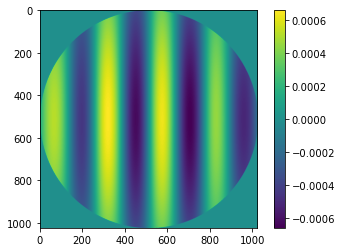

In [61]:
%%timeit
loss, grads = loss_func(model, 1e-5, psf_null)

214 ms ± 1.26 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
optax.adam?

Signature:
optax.adam(
    learning_rate: Union[float, Callable[[Union[jax._src.numpy.ndarray.ndarray, float, int]], Union[jax._src.numpy.ndarray.ndarray, float, int]]],
    b1: float = 0.9,
    b2: float = 0.999,
    eps: float = 1e-08,
    eps_root: float = 0.0,
    mu_dtype: Union[Any, NoneType] = None,
) -> optax._src.base.GradientTransformation
Docstring:
The classic Adam optimiser.

Adam is an SGD variant with learning rate adaptation. The `learning_rate`
used for each weight is computed from estimates of first- and second-order
moments of the gradients (using suitable exponential moving averages).

References:
  Kingma et al, 2014: https://arxiv.org/abs/1412.6980

Args:
  learning_rate: this is a fixed global scaling factor.
  b1: the exponential decay rate to track the first moment of past gradients.
  b2: the exponential decay rate to track the second moment of past gradients.
  eps: a small constant applied to denominator outside of the square root
    (as in the Adam paper) 

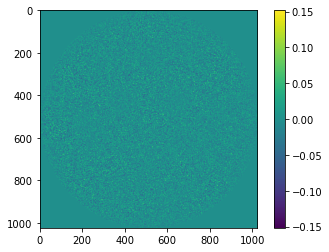

In [48]:
tree_structure(grads)

PyTreeDef(CustomNode(<class '__main__.OpticalSystem'>[(('layers',), (), ())], [[CustomNode(<class '__main__.CreateWavefront'>[(('x', 'y', 'aperture'), ('size_in', 'size_out'), (1024, 1024))], [None, None, None]), CustomNode(<class '__main__.MultiplyArray'>[(('array',), ('size_in', 'size_out'), (1024, 1024))], [None]), CustomNode(<class '__main__.AddPhase'>[(('array',), ('size_in', 'size_out'), (1024, 1024))], [*]), CustomNode(<class '__main__.MFT'>[((), ('size_in', 'size_out', 'wavel_scale'), (1024, 1024, 0.0001))], [])]]))

'OpticalSystem(layers=[CreateWavefront(size_in=1024, size_out=1024, x=None, y=None, aperture=None), MultiplyArray(size_in=1024, size_out=1024, array=None), AddPhase(size_in=1024, size_out=1024, array=f64[1024,1024]), MFT(size_in=1024, size_out=1024, wavel_scale=0.0001)])'

In [54]:
dir(jax)

['ShapeDtypeStruct',
 'ShapedArray',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_src',
 'abstract_arrays',
 'ad',
 'ad_checkpoint',
 'api_util',
 'block_until_ready',
 'check_tracer_leaks',
 'checking_leaks',
 'checkpoint',
 'checkpoint_policies',
 'closure_convert',
 'config',
 'core',
 'curry',
 'custom_batching',
 'custom_derivatives',
 'custom_gradient',
 'custom_ivjp',
 'custom_jvp',
 'custom_transpose',
 'custom_vjp',
 'debug_infs',
 'debug_nans',
 'default_backend',
 'default_matmul_precision',
 'default_prng_impl',
 'device_count',
 'device_get',
 'device_put',
 'device_put_replicated',
 'device_put_sharded',
 'devices',
 'disable_jit',
 'distributed',
 'dtypes',
 'enable_checks',
 'enable_custom_prng',
 'ensure_compile_time_eval',
 'errors',
 'eval_shape',
 'experimental',
 'flatten_fun_nokwargs',
 'flatten_util',
 'float0',
 'grad',
 'hessian',
 'host_count',
 'host_id',
 'ho

In [36]:
params

OpticalSystem(layers=[CreateWavefront(size_in=1024, size_out=1024, x=None, y=None, aperture=None), MultiplyArray(size_in=1024, size_out=1024, array=DeviceArray([[False, False, False, ..., False, False, False],
             [False, False, False, ..., False, False, False],
             [False, False, False, ..., False, False, False],
             ...,
             [False, False, False, ..., False, False, False],
             [False, False, False, ..., False, False, False],
             [False, False, False, ..., False, False, False]], dtype=bool)), AddPhase(size_in=1024, size_out=1024, array=DeviceArray([[1.22502277, 2.20312596, 3.90169384, ..., 2.99463372,
              0.60032491, 0.56259735],
             [4.05211114, 2.41192072, 3.69947179, ..., 5.83430296,
              2.11311142, 0.39658791],
             [0.47104939, 0.16453375, 4.38619732, ..., 1.23485042,
              0.71774144, 5.64735649],
             ...,
             [2.28008542, 4.40467676, 0.57094144, ..., 5.19742838,


In [37]:
static

OpticalSystem(layers=[CreateWavefront(size_in=1024, size_out=1024, x=0.0, y=0.0, aperture=0), MultiplyArray(size_in=1024, size_out=1024, array=None), AddPhase(size_in=1024, size_out=1024, array=None), MFT(size_in=1024, size_out=1024, wavel_scale=0.0001)])

In [15]:
updates

OpticalSystem(layers=[CreateWavefront(size_in=1024, size_out=1024, x=None, y=None, aperture=None), MultiplyArray(size_in=1024, size_out=1024, array=None), AddPhase(size_in=1024, size_out=1024, array=None), MFT(size_in=1024, size_out=1024, wavel_scale=0.0001)])

In [16]:
grads

OpticalSystem(layers=[CreateWavefront(size_in=1024, size_out=1024, x=None, y=None, aperture=None), MultiplyArray(size_in=1024, size_out=1024, array=None), AddPhase(size_in=1024, size_out=1024, array=None), MFT(size_in=1024, size_out=1024, wavel_scale=0.0001)])

In [17]:
grads.layers

[CreateWavefront(size_in=1024, size_out=1024, x=None, y=None, aperture=None),
 MultiplyArray(size_in=1024, size_out=1024, array=None),
 AddPhase(size_in=1024, size_out=1024, array=None),
 MFT(size_in=1024, size_out=1024, wavel_scale=0.0001)]

In [186]:
struc.num_nodes

12

In [188]:
struc.num_leaves

6

In [187]:
struc

PyTreeDef(CustomNode(<class '__main__.OpticalSystem'>[(('layers',), (), ())], [[CustomNode(<class '__main__.CreateWavefront'>[(('x', 'y', 'aperture'), ('size_in', 'size_out'), (1024, 1024))], [*, *, *]), CustomNode(<class '__main__.MultiplyArray'>[(('array',), ('size_in', 'size_out'), (1024, 1024))], [*]), *, CustomNode(<class '__main__.MultiplyArray'>[(('array',), ('size_in', 'size_out'), (1024, 1024))], [*]), CustomNode(<class '__main__.MFT'>[((), ('size_in', 'size_out', 'wavel_scale'), (1024, 1024, 0.0001))], [])]]))

TypeError: unsupported operand type(s) for +: 'OpticalSystem' and 'DeviceArray'

In [171]:
psf = Mosys(1e-5)

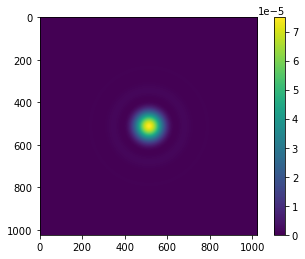

In [172]:
plt.imshow(psf)
plt.colorbar()

In [173]:
print(np.sum(psf))

0.9637765983557325


In [174]:
# Use this on the osys object to see how to stucutre the diffable params pytree input to filer_jit, _grad etc



In [175]:
type(struc)

jaxlib.xla_extension.PyTreeDef

In [176]:
ins = eqx.tree_pformat(Mosys).split('), ')

In [177]:
for i in range(len(ins)):
    print(ins[i])

OpticalSystem(layers=[CreateWavefront(size_in=1024, size_out=1024, x=0.0, y=0.0, aperture=0
MultiplyArray(size_in=1024, size_out=1024, array=bool[1024,1024]
<function NormaliseWavefront>, MultiplyArray(size_in=1024, size_out=1024, array=f64[1024,1024]
MFT(size_in=1024, size_out=1024, wavel_scale=0.0001)])


In [178]:
struc.num_leaves

6

In [182]:
dir(Mosys)

['__abstractmethods__',
 '__annotations__',
 '__call__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_has_dataclass_init',
 'layers',
 'tree_flatten',
 'tree_unflatten']

In [60]:
a = struc.children()

In [61]:
a

[PyTreeDef([CustomNode(<class '__main__.CreateWavefront'>[(('x', 'y', 'aperture'), ('size_in', 'size_out'), (1024, 1024))], [*, *, *]), CustomNode(<class '__main__.MultiplyArray'>[(('array',), ('size_in', 'size_out'), (1024, 1024))], [*]), CustomNode(<class '__main__.MultiplyArray'>[(('array',), ('size_in', 'size_out'), (1024, 1024))], [*]), CustomNode(<class '__main__.MFT'>[((), ('size_in', 'size_out', 'wavel_scale'), (1024, 1024, 0.0))], [])])]

---

## Construct Optical System

In [16]:
osys = poppy.OpticalSystem(pupil_diameter=3*u.meter)
osys.add_pupil(poppy.CircularAperture(radius=0.5*u.meter))    
osys.add_image(poppy.RectangularFieldStop(width=0.5*u.arcsec, height=10*u.arcsec) )
osys.add_pupil(poppy.CircularAperture(radius=1*u.meter))   # reimaged pupil in spectrograph; typically would have a grating here  
osys.add_detector(pixelscale=0.010*u.arcsec/u.pixel, fov_arcsec=5.0)  

In [337]:
for i in range(len(osys.planes)):
    print(osys.planes[i].pixelscale)

None
None
None
0.01 arcsec / pix


In [333]:
osys.planes[-1].fov_arcsec.to(u.radian)

<Quantity 2.42406841e-05 rad>

In [310]:
# radius = 6.5/2
# lyot_radius = 6.5/2.5
# pixelscale = 0.060

# osys = poppy.OpticalSystem("test", oversample=8)
# osys.add_pupil( poppy.CircularAperture(radius=radius), name='Entrance Pupil')
# osys.add_image( poppy.CircularOcculter(radius = 0.1) )
# osys.add_pupil( poppy.CircularAperture(radius=lyot_radius), name='Lyot Pupil')
# osys.add_detector(pixelscale=pixelscale, fov_arcsec=5.0)

In [311]:
# import webbpsf
# osys = p.load(open("../NIRISS_osys.p", 'rb'))

In [17]:
min_wavel = 5e-6
max_wavel = 10e-6
nwavels = 3

wavels = np.linspace(min_wavel, max_wavel, nwavels)

In [18]:
fits_psf, operations_list_out = osys.calc_psf(wavels, compile_operations=True)

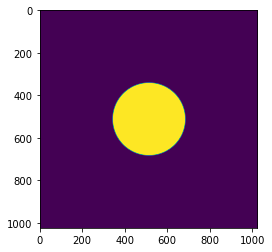

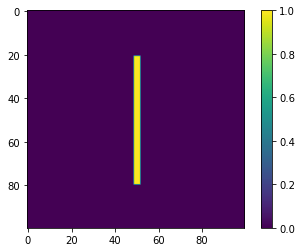

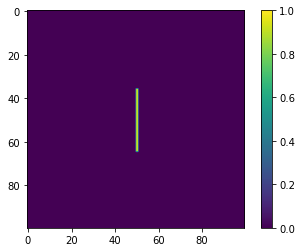

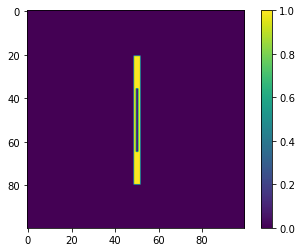

In [327]:
arr0 = operations_list_out[0][4][1]['array']
c = arr0.shape[0]//2
s = 50

plt.imshow(np.abs(arr0)[c-s:c+s, c-s:c+s])
plt.colorbar()
plt.show()

arr1 = operations_list_out[-1][4][1]['array']
plt.imshow(np.abs(arr1)[c-s:c+s, c-s:c+s])
plt.colorbar()
plt.show()

res = np.abs(arr0) - np.abs(arr1) 
plt.imshow(res[c-s:c+s, c-s:c+s])
plt.colorbar()
plt.show()

In [314]:
operations_list_out[0]

[['Array Multiplication',
  {'array': array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])}],
 ['Complex Normalisation', {}],
 ['Padding', {'shape': (1024, 1024), 'factor': 2}],
 ['FFT', {'shape': (2048, 2048)}],
 ['Array Multiplication',
  {'array': array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          ...,
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j

In [279]:
# Note this needs to be re-run if you changed something in a function

Layer_dict = {
    # 'Initialise wavefront': create_wavefront,
    'Array Multiplication': MultiplyArray,
    'Scalar Multiplication': MultiplyScalar,
    
    'Array Addition': AddArray,
    'Scalar Addition': AddScalar,
    
    # 'Interpolation': interpolate_prim,
    'Complex Normalisation': NormaliseWavefront,
    'Padding': Pad,
    'Depadding': Crop,
    # 'Rotation': rotate,
    # 'Invertion': Layer.Invert,
    'FFT': FFT,
    'IFFT': IFFT,
    'MFT': MFT,
    }

In [280]:
wavel_idx = -1
wavel = wavels[wavel_idx]
operations_list = operations_list_out[wavel_idx]

## Note: 
The first entry to operations_list will have nwavels more layers than the rest since the other final wavefronts are added to the first one.

This could be solved by auto-compiling the osys from the last (or just not the first) wavelength array. This would force us to auto-parametries the layers which need to be to get proper behaviour

In [281]:
for i in range(len(operations_list_out)):
    print(len(operations_list_out[i]))

10


In [282]:
for i in range(len(operations_list)):
    op = operations_list[i][0]
    keys = list(operations_list[i][1].keys())
    print("{}\n{}\n".format(op, keys))
    # print(operations_list[i][1])

Array Multiplication
['array']

Complex Normalisation
[]

Padding
['shape', 'factor']

FFT
['shape']

Array Multiplication
['array']

IFFT
['shape']

Array Multiplication
['array']

Depadding
['shape', 'factor']

MFT
['nlamD', 'npup', 'npix']

Scalar Multiplication
['value']



In [283]:
static_planes = [True, True, True, True, True, True, True, True, False, True]
params_in =     [None, None, None, None, None, None, None, None, wavels[0], None]
print(len(operations_list))
print(len(static_planes))

10
10


In [284]:
wavel_idx = -1
wavel = wavels[wavel_idx]
operations_list = operations_list_out[wavel_idx]


current_size = 1024
layers = []
for i in range(len(operations_list)):
    operation = operations_list[i]
    key, vals_dict = operation[0], operation[1]
    static = static_planes[i]
    print(i, static, key)
    
    if key == 'Initialise wavefront':
        pass
    
    elif key == 'Array Multiplication':
        array = vals_dict['array']
        layer = Layer_dict[key](current_size, static, array)
        
    elif key == 'Scalar Multiplication':
        value = vals_dict['value']
        layer = Layer_dict[key](current_size, static, value)
        
    elif key == 'Complex Normalisation':
        layer = Layer_dict[key](current_size)
        
    elif key == 'Padding':
        pad_factor = vals_dict['factor']
        size_in = current_size
        size_out = int(current_size * pad_factor)
        layer = Layer_dict[key](size_in, size_out)
        current_size = size_out
        
    elif key == 'Depadding':
        pad_factor = vals_dict['factor']
        size_in = current_size
        size_out = current_size // pad_factor
        layer = Layer_dict[key](size_in, size_out)
        current_size = size_out
        
    elif key == 'FFT':
        layer = Layer_dict[key](current_size)
        
    elif key == 'IFFT':
        layer = Layer_dict[key](current_size)        
        
    elif key == 'MFT':
        size_in = current_size
        size_out = int(vals_dict['npix'])
        wavel_scale = float(vals_dict['nlamD'] * wavel)
        wavel = wavel
        layer = Layer_dict[key](size_in, size_out, wavel_scale, static, wavel)
                                # size_in, size_out, wavel_scale, static, static_wavel
        current_size = size_out
        
    else:
        raise NotImplementedError("{} is not Implemented".format(key))

    layers.append(layer)


0 True Array Multiplication
1 True Complex Normalisation
2 True Padding
3 True FFT
4 True Array Multiplication
5 True IFFT
6 True Array Multiplication
7 True Depadding
8 False MFT
9 True Scalar Multiplication


In [285]:
def model(X, osys):
    # wavels = np.array([X[0]])
    # positions = [X[1:]]
    
    wavels = np.array(X[:3])
    positions = np.array([X[3:]])
    print(wavels)
    print(positions[:, 0])
    
    # Note the hard part of building a model is how to format this input list
    params_all = []
    for j in range(len(wavels)):
        params_temp = []
        for i in range(len(static_planes)):
            if static_planes[i]:
                params_temp.append(None)
            else:
                params_temp.append(wavels[j])
        params_all.append(params_temp)
            
    psfs = osys.propagate(positions, wavels, params_all)
    psf = np.sum(np.array(psfs), axis=0)
    return psf

# @eqx.filter_jit
def loss(X, osys, data):
    psf = model(X, osys)
    return np.sum(np.square(psf - data))

loss_grad = value_and_grad(loss)
loss_grad_jit = jit(loss_grad)

In [286]:
Mosys = OpticalSystem(layers)
wavel_in = wavels[0]+1e-7
wavels_in = [wavels[0]+1e-7, wavels[0]+2e-7, wavels[0]+3e-7]
x_in, y_in = 1e-3, 1e-3
positions = np.array([x_in, y_in])

poppy_psf = fits_psf[0].data
data = poppy_psf
X_start1 = np.array([wavel_in, x_in, y_in])
X_start2 = np.array([wavels_in[0], wavels_in[1], wavels_in[2], x_in, y_in])

In [287]:
# start1 = model(X_start1, Mosys)

In [288]:
start2 = model(X_start2, Mosys)

[5.1e-06 5.2e-06 5.3e-06]
[0.001]


ValueError: vmap got inconsistent sizes for array axes to be mapped:
arg 0 has shape (2,) and axis 0 is to be mapped
arg 1 has shape (2,) and axis 0 is to be mapped
arg 2 has shape (3,) and axis 0 is to be mapped
arg 3 has shape () and axis None is to be mapped
so
args 0, 1 have axes to be mapped of size 2
arg 2 has an axis to be mapped of size 3

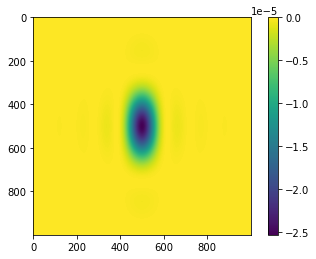

In [196]:
res = start1 - start2

plt.imshow(res)
plt.colorbar()
plt.show()

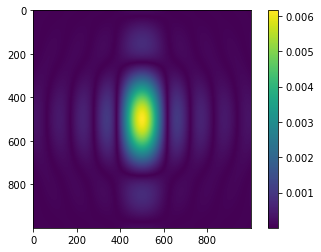

In [198]:
plt.imshow(start2**0.5)
plt.colorbar()
plt.show()

In [165]:
loss(X_start, Mosys, data)

[5.1e-06]
(1,)


DeviceArray(1.79386017e-09, dtype=float64)

In [166]:
loss_grad(X_start, Mosys, data)

Traced<ConcreteArray([5.1e-06], dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = DeviceArray([5.1e-06], dtype=float64)
  tangent = Traced<ShapedArray(float64[1])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[1]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x31e87f1d0>, invars=(Traced<ShapedArray(float64[]):JaxprTrace(level=1/0)>,), outvars=[<weakref at 0x31e8e18b0; to 'JaxprTracer' at 0x31e8e1040>], primitive=broadcast_in_dim, params={'shape': (1,), 'broadcast_dimensions': ()}, source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x3127adbf0>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
(1,)


(DeviceArray(1.79386017e-09, dtype=float64),
 DeviceArray([3.51624070e-02, 1.05687036e-13, 4.93164516e-15,
              0.00000000e+00, 0.00000000e+00], dtype=float64))

In [167]:
loss_grad_jit(X_start, Mosys, data)

Traced<ShapedArray(float64[1])>with<JVPTrace(level=2/1)> with
  primal = Traced<ShapedArray(float64[1])>with<DynamicJaxprTrace(level=0/1)>
  tangent = Traced<ShapedArray(float64[1])>with<JaxprTrace(level=1/1)> with
    pval = (ShapedArray(float64[1]), *)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x31e87f310>, invars=(Traced<ShapedArray(float64[]):JaxprTrace(level=1/1)>,), outvars=[<weakref at 0x32b9aaa40; to 'JaxprTracer' at 0x32b9aa7c0>], primitive=broadcast_in_dim, params={'shape': (1,), 'broadcast_dimensions': ()}, source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x31e8c4b30>, name_stack=NameStack(stack=(Transform(name='jvp'),))))
(1,)


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(int64[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
'num' argument of jnp.linspace
While tracing the function loss at /var/folders/28/6s47s91d14ldjdrljs4d1hxw0000gn/T/ipykernel_62622/2583494225.py:21 for jit, this concrete value was not available in Python because it depends on the value of the argument 'osys'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [37]:
psf = model(X, Mosys)
poppy_psf = fits_psf[0].data

propagte: 5e-06
MFT: 5e-06


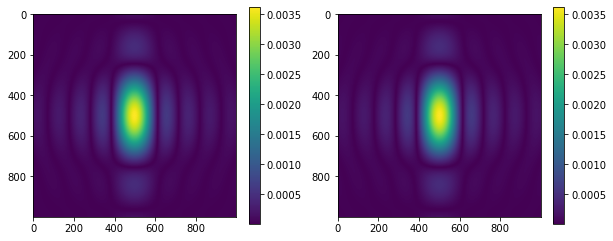

In [40]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(psf**0.5)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(poppy_psf**0.5)
plt.colorbar()
plt.show()

In [42]:
np.allclose(poppy_psf, psf)

DeviceArray(True, dtype=bool)

In [35]:
print(np.sum(psf))

0.3109158464519873


In [285]:
psfs = Mosys.propagate_mult(positions, wavels, params)

DeviceArray(False, dtype=bool)

In [ ]:
plt.imshow(fits_psf)